# Setup

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.dont_write_bytecode = True

# Imports

In [2]:
import numpy as np
from src.data_preprocessing import preprocess_data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import defaultdict
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# Récupération des données & fusion des csv & pré-traitement

In [3]:
preprocess_data(input_folder="../data/", output_file="../data/matches_clean.csv")

c:\Users\Jhinnz\Desktop\GITLAB\ter-m1\bookmaker-model\src\data_preprocessing.py:52: DtypeWarning: Columns (2,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(f"{input_folder}/all_matches_raw.csv", sep=',')


Structure du DataFrame :
     gameid datacompleteness  \
0  TRLH3/33         complete   
1  TRLH3/33         complete   
2  TRLH3/33         complete   
3  TRLH3/33         complete   
4  TRLH3/33         complete   

                                                 url  league  year   split  \
0  http://matchhistory.na.leagueoflegends.com/en/...  EU LCS  2014  Spring   
1  http://matchhistory.na.leagueoflegends.com/en/...  EU LCS  2014  Spring   
2  http://matchhistory.na.leagueoflegends.com/en/...  EU LCS  2014  Spring   
3  http://matchhistory.na.leagueoflegends.com/en/...  EU LCS  2014  Spring   
4  http://matchhistory.na.leagueoflegends.com/en/...  EU LCS  2014  Spring   

   playoffs                 date  game  patch  ...  opp_csat25 golddiffat25  \
0         0  2014-01-14 17:52:02   1.0   3.15  ...       206.0         76.0   
1         0  2014-01-14 17:52:02   1.0   3.15  ...       140.0       -888.0   
2         0  2014-01-14 17:52:02   1.0   3.15  ...       225.0        621.0 

Transformation des matchs: 100%|██████████| 87544/87544 [31:38<00:00, 46.11it/s] 


Colonnes du DataFrame final : ['gameid', 'Blue_team_teamname', 'Blue_team_date', 'Blue_team_result', 'Blue_team_kills', 'Blue_team_deaths', 'Blue_team_assists', 'Blue_team_teamkills', 'Blue_team_teamdeaths', 'Blue_team_doublekills', 'Blue_team_triplekills', 'Blue_team_quadrakills', 'Blue_team_pentakills', 'Blue_team_gamelength', 'Blue_team_dragons', 'Blue_team_barons', 'Blue_team_goldat15', 'Blue_team_towers', 'Blue_team_csat10', 'Blue_team_goldat10', 'Blue_team_xpat10', 'Blue_team_opp_goldat10', 'Blue_team_opp_xpat10', 'Blue_team_opp_csat10', 'Blue_team_golddiffat10', 'Blue_team_xpdiffat10', 'Blue_team_csdiffat10', 'Blue_team_killsat10', 'Blue_team_assistsat10', 'Blue_team_deathsat10', 'Blue_team_side', 'Red_team_teamname', 'Red_team_date', 'Red_team_result', 'Red_team_kills', 'Red_team_deaths', 'Red_team_assists', 'Red_team_teamkills', 'Red_team_teamdeaths', 'Red_team_doublekills', 'Red_team_triplekills', 'Red_team_quadrakills', 'Red_team_pentakills', 'Red_team_gamelength', 'Red_team

# Création des features

In [ ]:
# Charger les données nettoyées
df = pd.read_csv("../data/matches_clean.csv")
# Trier le dataset par date pour s'assurer que les calculs de performance récente sont corrects
df['Blue_team_date'] = pd.to_datetime(df['Blue_team_date'], format='%Y-%m-%d %H:%M:%S')

df.sort_values(by='Blue_team_date', inplace=True)

confrontations = defaultdict(list)
team_matches = defaultdict(list)
df = df.dropna(subset=['Blue_team_teamname', 'Red_team_teamname'])

for _, row in df.iterrows():
    team_matches[row['Blue_team_teamname']].append(row)
    team_matches[row['Red_team_teamname']].append(row)
    key = tuple(sorted([row['Blue_team_teamname'], row['Red_team_teamname']]))
    confrontations[key].append(row)


# Fonction pour obtenir les 5 derniers matchs entre deux équipes
def get_last_n_matches_from_dict(team1, team2, current_gameid = None, n_matches=5):
    key = tuple(sorted([team1, team2]))
    matches = confrontations.get(key, [])

    # Trouver l'indice du match courant dans la liste
    if current_gameid is None:
        # Si le gameid est None, on ne peut pas trouver l'indice
        return matches[-n_matches:] if len(matches) >= n_matches else matches
    
    index = next((i for i, match in enumerate(matches) if match['gameid'] == current_gameid), None)
    if index is None:
        # Le match n’est pas encore dans la liste → on est en train de le traiter
        # Donc on peut prendre directement les 5 derniers avant la fin de la liste
        return matches[-n_matches:]
    
    # Retourne les 5 matchs avant ce match
    return matches[max(0, index - n_matches):index]

def get_last_5_matches(team_name, current_gameid=None,n_matches=5):
    # Vérifier si l'équipe existe dans le dictionnaire
    if team_name not in team_matches:
        return np.nan
    # Trouver l'indice du match courant dans la liste
    if current_gameid is None:
        # Si le gameid est None, on ne peut pas trouver l'indice
        return team_matches[team_name][-n_matches:] if len(team_matches[team_name]) >= n_matches else team_matches[team_name]
    index = next((i for i, match in enumerate(team_matches[team_name]) if match['gameid'] == current_gameid), None)
    if index is None:
        # Le match n’est pas encore dans la liste → on est en train de le traiter
        # Donc on peut prendre directement les 5 derniers avant la fin de la liste
        return team_matches[team_name][-n_matches:]
    # Retourne les 5 matchs avant ce match        
    return team_matches[team_name][max(0, index - n_matches):index]

# Calculer le taux de victoire sur les 5 derniers matchs pour chaque équipe
def get_last_5_matches_1v1_win_rate(team_1, team_2, current_gameid):
    last_5_matches = get_last_n_matches_from_dict(team_1, team_2, current_gameid, n_matches=8)
    if len(last_5_matches) == 0:
        return np.nan

    team_1_wins = 0
    for match in last_5_matches:
        if match['Blue_team_teamname'] == team_1:
            team_1_wins += match['Blue_team_result']
        else:
            team_1_wins += match['Red_team_result']
    return team_1_wins / len(last_5_matches)

# Calculer le ratio K/D sur les 5 derniers matchs pour chaque équipe
def get_last_5_matches_1v1_kd_ratio(team_1, team_2, current_gameid):
    last_5_matches = get_last_n_matches_from_dict(team_1, team_2, current_gameid,n_matches=8)
    if len(last_5_matches) == 0:
        return np.nan
    team_1_kills = 0
    team_1_deaths = 0
    for match in last_5_matches:
        if match['Blue_team_teamname'] == team_1:
            team_1_kills += match['Blue_team_kills']
            team_1_deaths += match['Blue_team_deaths']
        else:
            team_1_kills += match['Red_team_kills']
            team_1_deaths += match['Red_team_deaths']
    if team_1_deaths == 0:
        return team_1_kills
    return team_1_kills / team_1_deaths

# Calculer le nombre moyen de dragons tués sur les 5 derniers matchs pour chaque équipe
def get_last_5_matches_1v1_dragons(team_1, team_2, current_gameid):
    last_5_matches = get_last_n_matches_from_dict(team_1, team_2, current_gameid, n_matches=8)
    if len(last_5_matches) == 0:
        return np.nan
    team_1_dragons = 0
    for match in last_5_matches:
        if match['Blue_team_teamname'] == team_1:
            team_1_dragons += match['Blue_team_dragons']
        else:
            team_1_dragons += match['Red_team_dragons']
    return team_1_dragons

# Calculer le nombre moyen de barons tués sur les 5 derniers matchs pour chaque équipe
def get_last_5_matches_1v1_barons(team_1, team_2, current_gameid):
    last_5_matches = get_last_n_matches_from_dict(team_1, team_2, current_gameid, n_matches=8)
    if len(last_5_matches) == 0:
        return np.nan
    team_1_barons = 0
    for match in last_5_matches:
        if match['Blue_team_teamname'] == team_1:
            team_1_barons += match['Blue_team_barons']
        else:
            team_1_barons += match['Red_team_barons']
    return team_1_barons


# def get_last_n_matches_opponent_winrate(team_1, current_gameid=None, n_matches=5, n_opponent_matches=10):
#     matches = get_last_5_matches(team_1, current_gameid, n_matches=n_matches)
#     if not matches:
#         return np.nan

#     total_winrate = 0
#     valid_opponent_count = 0

#     for match in matches:
#         # Identifier l’adversaire
#         if match['Blue_team_teamname'] == team_1:
#             opponent = match['Red_team_teamname']
#         else:
#             opponent = match['Blue_team_teamname']

#         # Récupérer les matchs récents de l’adversaire
#         opp_matches = get_last_5_matches(opponent, current_gameid, n_matches=n_opponent_matches)
#         if not opp_matches:
#             continue

#         opp_wins = 0
#         for m in opp_matches:
#             if m['Blue_team_teamname'] == opponent:
#                 opp_wins += m['Blue_team_result']
#             else:
#                 opp_wins += m['Red_team_result']
        
#         winrate = opp_wins / len(opp_matches)
#         total_winrate += winrate
#         valid_opponent_count += 1

#     if valid_opponent_count == 0:
#         return np.nan

#     return total_winrate / valid_opponent_count

In [ ]:
# Calculer le taux de victoire sur les 5 derniers matchs pour chaque équipe
df['blue_team_recent_win_rate'] = df.groupby('Blue_team_teamname')['Blue_team_result'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
df['red_team_recent_win_rate'] = df.groupby('Red_team_teamname')['Red_team_result'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())

print("Taux de victoire sur les 5 derniers matchs calculé.")

# Calculer le ratio K/D sur les 5 derniers matchs pour chaque équipe
df['blue_team_recent_kd_ratio'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=15, min_periods=1).mean()).reset_index(level=0, drop=True)
df['red_team_recent_kd_ratio'] = df.groupby('Red_team_teamname').apply(lambda x: (x['Red_team_kills'] / (x['Red_team_deaths'] + 1e-6)).rolling(window=15, min_periods=1).mean()).reset_index(level=0, drop=True)

print("Ratio K/D sur les 5 derniers matchs calculé.")

# Calculer le nombre moyen de dragons tués sur les 5 derniers matchs pour chaque équipe
df['blue_team_recent_dragons'] = df.groupby('Blue_team_teamname')['Blue_team_dragons'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
df['red_team_recent_dragons'] = df.groupby('Red_team_teamname')['Red_team_dragons'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())

print("Nombre moyen de dragons tués sur les 5 derniers matchs calculé.")

# Calculer le nombre moyen de barons tués sur les 5 derniers matchs pour chaque équipe
df['blue_team_recent_barons'] = df.groupby('Blue_team_teamname')['Blue_team_barons'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
df['red_team_recent_barons'] = df.groupby('Red_team_teamname')['Red_team_barons'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())

print("Nombre moyen de barons tués sur les 5 derniers matchs calculé.")

df['blue_team_last3_win_rate'] = df.groupby('Blue_team_teamname')['Blue_team_result'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['red_team_last3_win_rate'] = df.groupby('Red_team_teamname')['Red_team_result'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

print("Taux de victoire sur les 3 derniers matchs calculé.")

# Calculer le ratio K/D sur les 3 derniers matchs pour chaque équipe
df['blue_team_last3_kd_ratio'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=3, min_periods=1).mean()).reset_index(level=0, drop=True)
df['red_team_last3_kd_ratio'] = df.groupby('Red_team_teamname').apply(lambda x: (x['Red_team_kills'] / (x['Red_team_deaths'] + 1e-6)).rolling(window=3, min_periods=1).mean()).reset_index(level=0, drop=True)

print("Ratio K/D sur les 3 derniers matchs calculé.")

# Ecart-type des kills, deaths, dragons et barons sur les 20 derniers matchs

df['blue_team_kd_ratio_std_20'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=20, min_periods=1).std()).reset_index(level=0, drop=True)
df['red_team_kd_ratio_std_20'] = df.groupby('Red_team_teamname').apply(lambda x: (x['Red_team_kills'] / (x['Red_team_deaths'] + 1e-6)).rolling(window=20, min_periods=1).std()).reset_index(level=0, drop=True)

df['blue_team_kills_std_20'] = df.groupby('Blue_team_teamname')['Blue_team_kills'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
df['red_team_kills_std_20'] = df.groupby('Red_team_teamname')['Red_team_kills'].transform(lambda x: x.rolling(window=20, min_periods=1).std())

df['blue_team_deaths_std_20'] = df.groupby('Blue_team_teamname')['Blue_team_deaths'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
df['red_team_deaths_std_20'] = df.groupby('Red_team_teamname')['Red_team_deaths'].transform(lambda x: x.rolling(window=20, min_periods=1).std())

df['blue_team_dragons_std_20'] = df.groupby('Blue_team_teamname')['Blue_team_dragons'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
df['red_team_dragons_std_20'] = df.groupby('Red_team_teamname')['Red_team_dragons'].transform(lambda x: x.rolling(window=20, min_periods=1).std())

df['blue_team_barons_std_20'] = df.groupby('Blue_team_teamname')['Blue_team_barons'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
df['red_team_barons_std_20'] = df.groupby('Red_team_teamname')['Red_team_barons'].transform(lambda x: x.rolling(window=20, min_periods=1).std())

print("Ecart-type des kills, deaths, dragons et barons, kd sur les 20 derniers matchs calculé.")

# df['blue_team_opponent_avg_winrate_last10'] = df.apply(lambda row: get_last_n_matches_opponent_winrate(row['Blue_team_teamname'], row['gameid'], n_matches=10), axis=1)
# df['red_team_opponent_avg_winrate_last10'] = df.apply(lambda row: get_last_n_matches_opponent_winrate(row['Red_team_teamname'], row['gameid'], n_matches=10), axis=1)

# print("Taux de victoire moyen de l'adversaire sur les 10 derniers matchs calculé.")

# Utiliser des transformations vectorisées pour calculer les caractéristiques
df['blue_team_recent_1v1_win_rate'] = df.apply(lambda row: get_last_5_matches_1v1_win_rate(row['Blue_team_teamname'], row['Red_team_teamname'], row['gameid']), axis=1)
df['red_team_recent_1v1_win_rate'] = df.apply(lambda row: get_last_5_matches_1v1_win_rate(row['Red_team_teamname'], row['Blue_team_teamname'], row['gameid']), axis=1)

print("Taux de victoire sur les 5 derniers matchs calculé. (1v1)")

df['blue_team_recent_1v1_kd_ratio'] = df.apply(lambda row: get_last_5_matches_1v1_kd_ratio(row['Blue_team_teamname'], row['Red_team_teamname'], row['gameid']), axis=1)
df['red_team_recent_1v1_kd_ratio'] = df.apply(lambda row: get_last_5_matches_1v1_kd_ratio(row['Red_team_teamname'], row['Blue_team_teamname'], row['gameid']), axis=1)

print("Ratio K/D sur les 5 derniers matchs calculé. (1v1)")

df['blue_team_recent_1v1_dragons'] = df.apply(lambda row: get_last_5_matches_1v1_dragons(row['Blue_team_teamname'], row['Red_team_teamname'], row['gameid']), axis=1)
df['red_team_recent_1v1_dragons'] = df.apply(lambda row: get_last_5_matches_1v1_dragons(row['Red_team_teamname'], row['Blue_team_teamname'], row['gameid']), axis=1)

print("Nombre moyen de dragons tués sur les 5 derniers matchs calculé. (1v1)")

df['blue_team_recent_1v1_barons'] = df.apply(lambda row: get_last_5_matches_1v1_barons(row['Blue_team_teamname'], row['Red_team_teamname'], row['gameid']), axis=1)
df['red_team_recent_1v1_barons'] = df.apply(lambda row: get_last_5_matches_1v1_barons(row['Red_team_teamname'], row['Blue_team_teamname'], row['gameid']), axis=1)

print("Nombre moyen de barons tués sur les 5 derniers matchs calculé. (1v1)")

# # Sauvegarder le dataset avec les nouvelles caractéristiques
df.to_csv('../data/dataset_with_recent_performance.csv', index=False)

Taux de victoire sur les 5 derniers matchs calculé.


C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['blue_team_recent_kd_ratio'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=15, min_periods=1).mean()).reset_index(level=0, drop=True)
C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby 

Ratio K/D sur les 5 derniers matchs calculé.
Nombre moyen de dragons tués sur les 5 derniers matchs calculé.
Nombre moyen de barons tués sur les 5 derniers matchs calculé.
Taux de victoire sur les 3 derniers matchs calculé.


C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['blue_team_last3_kd_ratio'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=3, min_periods=1).mean()).reset_index(level=0, drop=True)
C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby 

Ratio K/D sur les 3 derniers matchs calculé.


C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['blue_team_kd_ratio_std_20'] = df.groupby('Blue_team_teamname').apply(lambda x: (x['Blue_team_kills'] / (x['Blue_team_deaths'] + 1e-6)).rolling(window=20, min_periods=1).std()).reset_index(level=0, drop=True)
C:\Users\Jhinnz\AppData\Local\Temp\ipykernel_5116\645095378.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Ecart-type des kills, deaths, dragons et barons, kd sur les 20 derniers matchs calculé.
Taux de victoire sur les 5 derniers matchs calculé. (1v1)
Ratio K/D sur les 5 derniers matchs calculé. (1v1)
Nombre moyen de dragons tués sur les 5 derniers matchs calculé. (1v1)
Nombre moyen de barons tués sur les 5 derniers matchs calculé. (1v1)


# Préparation des données

In [ ]:
df = pd.read_csv("../data/dataset_with_recent_performance.csv")

relevant_features = [
    'blue_team_recent_win_rate',
    'red_team_recent_win_rate',
    'blue_team_recent_kd_ratio',
    'red_team_recent_kd_ratio',
    'blue_team_recent_dragons',
    'red_team_recent_dragons',
    'blue_team_recent_barons',
    'red_team_recent_barons',
    'blue_team_last3_win_rate',
    'red_team_last3_win_rate',
    'blue_team_last3_kd_ratio',
    'red_team_last3_kd_ratio',
    'blue_team_kd_ratio_std_20',
    'red_team_kd_ratio_std_20',
    'blue_team_kills_std_20',
    'red_team_kills_std_20',
    'blue_team_deaths_std_20',
    'red_team_deaths_std_20',
    'blue_team_dragons_std_20',
    'red_team_dragons_std_20',
    'blue_team_barons_std_20',
    'red_team_barons_std_20',
    # 'blue_team_opponent_avg_winrate_last10',  # décommenter si utilisé
    # 'red_team_opponent_avg_winrate_last10',   # décommenter si utilisé
    'blue_team_recent_1v1_win_rate',
    'red_team_recent_1v1_win_rate',
    'blue_team_recent_1v1_kd_ratio',
    'red_team_recent_1v1_kd_ratio',
    'blue_team_recent_1v1_dragons',
    'red_team_recent_1v1_dragons',
    'blue_team_recent_1v1_barons',
    'red_team_recent_1v1_barons'
]

# Sélectionner les colonnes pertinentes
X = df[relevant_features]
y = df['Blue_team_result']
X = X.fillna(0)  # Remplacer les NaN par 0
X = X.replace([np.inf, -np.inf], 0)  # Remplacer les infinis par 0
# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)


# Entrainement du model

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
# XGBoost Classifierimport xgboost as xgb

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,   # Pénalisation L1 → sparse model
    reg_lambda=2.0,  # Pénalisation L2 → réduit les gros poids
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Random Forest Classifier:
Accuracy: 0.8499428571428571
              precision    recall  f1-score   support

           0       0.81      0.88      0.85     12272
           1       0.89      0.82      0.85     13978

    accuracy                           0.85     26250
   macro avg       0.85      0.85      0.85     26250
weighted avg       0.85      0.85      0.85     26250



c:\Users\Jhinnz\Desktop\GITLAB\ter-m1\bookmaker-model\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier:
Accuracy: 0.8563428571428572
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     12272
           1       0.91      0.81      0.86     13978

    accuracy                           0.86     26250
   macro avg       0.86      0.86      0.86     26250
weighted avg       0.86      0.86      0.86     26250



# Importance du model (poids des colonnes)

Feature Importances du modèle de base (calibrated_xgb) : [0.02389019 0.02878525 0.00405397 0.00469568 0.00360749 0.00403835
 0.0053813  0.00444041 0.33249393 0.3633401  0.06918891 0.07560943
 0.00327831 0.0038263  0.00544612 0.00610201 0.00405131 0.00430099
 0.00394627 0.0036239  0.00347903 0.004291   0.00506822 0.00633023
 0.00474476 0.00417119 0.00482631 0.00390808 0.00468138 0.00439956]


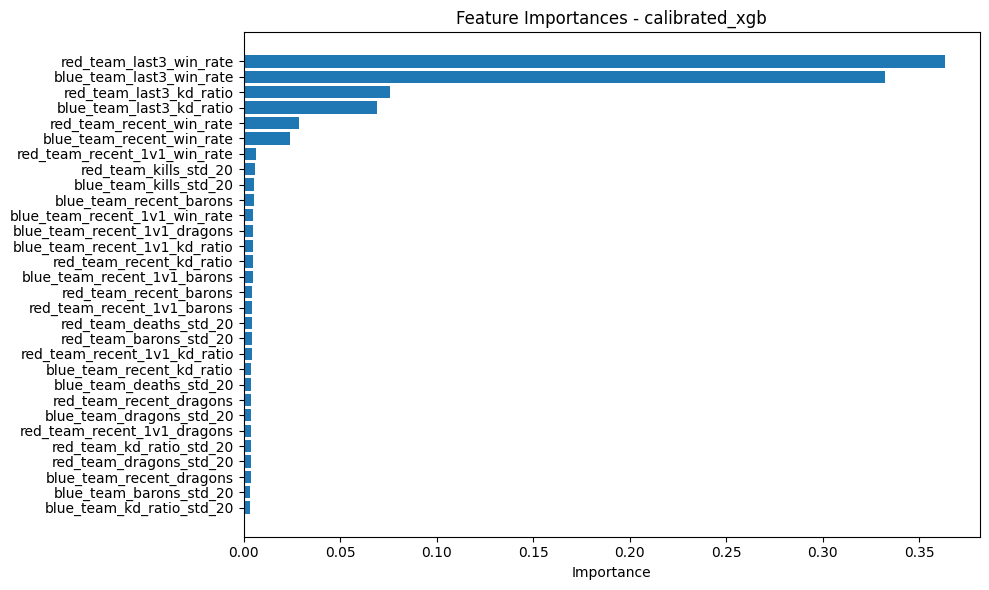

In [6]:
# Récupérer le modèle de base depuis le CalibratedClassifierCV (cas cv='prefit')
base_model = xgb

# Vérifier si le modèle de base a l'attribut feature_importances_
if hasattr(base_model, 'feature_importances_'):
    feature_importances = base_model.feature_importances_
    print("Feature Importances du modèle de base (calibrated_xgb) :", feature_importances)
else:
    print("Le modèle de base n'a pas d'attribut 'feature_importances_'")

# Optionnel : remplace ceci par tes vrais noms de colonnes
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"{relevant_features[i]}" for i in range(len(feature_importances))]

# Tri décroissant des importances
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]
sorted_names = np.array(feature_names)[sorted_idx]

# Affichage
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances)
plt.xlabel("Importance")
plt.title("Feature Importances - calibrated_xgb")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Prédicition de cotes

In [58]:
team_1 = "Karmine Corp"
team_2 = "G2 Esports"
# No current gameid provided
def predict_winner_proba(team_1, team_2):
    current_gameid = None
    # Get the last 5 matches between the two teams
    last_5_matches_team_1 = get_last_5_matches(team_1, n_matches=10)
    last_5_matches_team_2 = get_last_5_matches(team_2, n_matches=10)

    df_to_predict = pd.DataFrame({
        'blue_team_recent_win_rate': np.mean([match['Blue_team_result'] for match in last_5_matches_team_1]),
        'red_team_recent_win_rate': np.mean([match['Red_team_result'] for match in last_5_matches_team_2]),
        'blue_team_recent_kd_ratio': np.mean([match['Blue_team_kills'] / (match['Blue_team_deaths'] + 1e-6) for match in last_5_matches_team_1]),
        'red_team_recent_kd_ratio': np.mean([match['Red_team_kills'] / (match['Red_team_deaths'] + 1e-6) for match in last_5_matches_team_2]),
        'blue_team_recent_dragons': np.mean([match['Blue_team_dragons'] for match in last_5_matches_team_1]),
        'red_team_recent_dragons': np.mean([match['Red_team_dragons'] for match in last_5_matches_team_2]),
        'blue_team_recent_barons': np.mean([match['Blue_team_barons'] for match in last_5_matches_team_1]),
        'red_team_recent_barons': np.mean([match['Red_team_barons'] for match in last_5_matches_team_2]),
        'blue_team_recent_1v1_win_rate': [get_last_5_matches_1v1_win_rate(team_1, team_2, current_gameid)],
        'red_team_recent_1v1_win_rate': [get_last_5_matches_1v1_win_rate(team_2, team_1, current_gameid)],
        'blue_team_recent_1v1_kd_ratio': [get_last_5_matches_1v1_kd_ratio(team_1, team_2, current_gameid)],
        'red_team_recent_1v1_kd_ratio': [get_last_5_matches_1v1_kd_ratio(team_2, team_1, current_gameid)],
        'blue_team_recent_1v1_dragons': [get_last_5_matches_1v1_dragons(team_1, team_2, current_gameid)],
        'red_team_recent_1v1_dragons': [get_last_5_matches_1v1_dragons(team_2, team_1, current_gameid)],
        'blue_team_recent_1v1_barons': [get_last_5_matches_1v1_barons(team_1, team_2, current_gameid)],
        'red_team_recent_1v1_barons': [get_last_5_matches_1v1_barons(team_2, team_1, current_gameid)],
        'blue_team_last3_win_rate': np.mean([match['Blue_team_result'] for match in last_5_matches_team_1[-3:]]),
        'red_team_last3_win_rate': np.mean([match['Red_team_result'] for match in last_5_matches_team_2[-3:]]),
        'blue_team_last3_kd_ratio': np.mean([match['Blue_team_kills'] / (match['Blue_team_deaths'] + 1e-6) for match in last_5_matches_team_1[-3:]]),
        'red_team_last3_kd_ratio': np.mean([match['Red_team_kills'] / (match['Red_team_deaths'] + 1e-6) for match in last_5_matches_team_2[-3:]]),
        'blue_team_kd_ratio_std_20': np.std([match['Blue_team_kills'] / (match['Blue_team_deaths'] + 1e-6) for match in last_5_matches_team_1[-20:]]),
        'red_team_kd_ratio_std_20': np.std([match['Red_team_kills'] / (match['Red_team_deaths'] + 1e-6) for match in last_5_matches_team_2[-20:]]),
        'blue_team_kills_std_20': np.std([match['Blue_team_kills'] for match in last_5_matches_team_1[-20:]]),
        'red_team_kills_std_20': np.std([match['Red_team_kills'] for match in last_5_matches_team_2[-20:]]),
        'blue_team_deaths_std_20': np.std([match['Blue_team_deaths'] for match in last_5_matches_team_1[-20:]]),
        'red_team_deaths_std_20': np.std([match['Red_team_deaths'] for match in last_5_matches_team_2[-20:]]),
        'blue_team_dragons_std_20': np.std([match['Blue_team_dragons'] for match in last_5_matches_team_1[-20:]]),
        'red_team_dragons_std_20': np.std([match['Red_team_dragons'] for match in last_5_matches_team_2[-20:]]),
        'blue_team_barons_std_20': np.std([match['Blue_team_barons'] for match in last_5_matches_team_1[-20:]]),
        'red_team_barons_std_20': np.std([match['Red_team_barons'] for match in last_5_matches_team_2[-20:]]),
    })

    # Remplacer les NaN par 0
    df_to_predict = df_to_predict.fillna(0)
    df_to_predict = df_to_predict.replace([np.inf, -np.inf], 0)
    # Normaliser les données
    # Assurez-vous que le scaler est ajusté sur les données d'entraînement
    scaler = StandardScaler()
    # Ajuster le scaler sur les données d'entraînement
    scaler.fit(X_train)
    df_to_predict = scaler.transform(df_to_predict)
    # Prédire les probabilités de victoire pour chaque équipe
    proba_team_1 = xgb.predict_proba(df_to_predict)[:, 1]
    proba_team_2 = xgb.predict_proba(df_to_predict)[:, 0]
    return proba_team_1[0], proba_team_2[0]

def predict_odds(team_1, team_2):
    p1a, p2a = predict_winner_proba(team_1, team_2)
    p1b, p2b = predict_winner_proba(team_2, team_1)

    # Moyenne des prédictions symétriques
    proba_team_1 = (p1a + p2b) / 2
    proba_team_2 = (p2a + p1b) / 2

    # marge maudite de 5%
    proba_team_1 = proba_team_1 * 1.05
    proba_team_2 = proba_team_2 * 1.05

    # Calcul des cotes
    odds_team_1 = 1 / proba_team_1
    odds_team_2 = 1 / proba_team_2
    return odds_team_1, odds_team_2

odds_team_1, odds_team_2 = predict_odds(team_1, team_2)
print(f"Odds for {team_1}: {odds_team_1:.2f}")
print(f"Odds for {team_2}: {odds_team_2:.2f}")

Odds for Karmine Corp: 1.82
Odds for G2 Esports: 1.99


c:\Users\Jhinnz\Desktop\GITLAB\ter-m1\bookmaker-model\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\Jhinnz\Desktop\GITLAB\ter-m1\bookmaker-model\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Sauvegarde du model

In [57]:
xgb.save_model("../models/xgboost_model.json")

# test avec les fichier src

## Setup

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.dont_write_bytecode = True

## Import

In [ ]:
from src.data_preprocessing import preprocess_data
from src.features import load_data, create_features
from src.model import generate_train, model_training
from src.predict import predict_odds

df, confrontations, team_matches = load_data()
create_features(df, confrontations, team_matches)
X_train, X_test, y_train, y_test, scaler_path = generate_train()
model_name = "XGBoost"
model, model_path = model_training(X_train, X_test, y_train, y_test, model_name)
team_1 = "Karmine Corp"
team_2 = "G2 Esports"

odds_team_1, odds_team_2 = predict_odds(team_1, team_2, model_path, scaler_path, confrontations, team_matches)
print(f"Odds for {team_1}: {odds_team_1:.2f}")
print(f"Odds for {team_2}: {odds_team_2:.2f}")


Taux de victoire sur les 5 derniers matchs calculé.
Ratio K/D sur les 5 derniers matchs calculé.
Nombre moyen de dragons tués sur les 5 derniers matchs calculé.
Nombre moyen de barons tués sur les 5 derniers matchs calculé.
Taux de victoire sur les 3 derniers matchs calculé.
Ratio K/D sur les 3 derniers matchs calculé.
Ecart-type des kills, deaths, dragons et barons, kd sur les 20 derniers matchs calculé.
Taux de victoire sur les 5 derniers matchs calculé. (1v1)
Ratio K/D sur les 5 derniers matchs calculé. (1v1)
Nombre moyen de dragons tués sur les 5 derniers matchs calculé. (1v1)
Nombre moyen de barons tués sur les 5 derniers matchs calculé. (1v1)


c:\Users\Jhinnz\Desktop\GITLAB\ter-m1\bookmaker-model\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:13:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier:
Accuracy: 0.8563428571428572
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     12272
           1       0.91      0.81      0.86     13978

    accuracy                           0.86     26250
   macro avg       0.86      0.86      0.86     26250
weighted avg       0.86      0.86      0.86     26250

Model XGBoost saved as ../models/XGBoost_model_20250512_201311.pkl
Odds for Karmine Corp: 1.82
Odds for G2 Esports: 1.99
